# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

_The data set corresponds to 17 campaings that were conducted between May 2008 and November 2010_

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [86]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree

from imblearn.over_sampling import SMOTE


In [2]:
bank_data_full = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
bank_data_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
col_list = bank_data_full.columns.to_list()
print(bank_data_full.shape)

#for col in col_list:
#    print(bank_data_full[col].value_counts())

bank_data_full = bank_data_full.drop('duration', axis=1)

bank_data_full = bank_data_full.replace('unknown', np.nan).dropna()

bank_data_full['was_contacted_before'] = (bank_data_full['pdays'] != 999).astype(int)
bank_data_full = bank_data_full.drop('pdays', axis=1)




(41188, 21)


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

_Increase the efficiency of the campaign by identifing which attributes make someone a good candidate for a long term subscription.  Additionally we'll want to maximize recall since calling someone who isn't going to subscribe has a minimal impact but missing a subscription is more detrimental to the bussiness_

In [5]:
col_list = bank_data_full.columns.to_list()
print(bank_data_full.shape)

#for col in col_list:
#    print(bank_data_full[col].value_counts())


bank_data_full.info()

(30488, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 30488 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   30488 non-null  int64  
 1   job                   30488 non-null  object 
 2   marital               30488 non-null  object 
 3   education             30488 non-null  object 
 4   default               30488 non-null  object 
 5   housing               30488 non-null  object 
 6   loan                  30488 non-null  object 
 7   contact               30488 non-null  object 
 8   month                 30488 non-null  object 
 9   day_of_week           30488 non-null  object 
 10  campaign              30488 non-null  int64  
 11  previous              30488 non-null  int64  
 12  poutcome              30488 non-null  object 
 13  emp.var.rate          30488 non-null  float64
 14  cons.price.idx        30488 non-null  float64
 15  cons.conf.id

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
#encode the bank data to 1 for yes and 0 for no
yes_no_columns = ['default', 'housing', 'loan', 'y']
for col in yes_no_columns:
    bank_data_full[col] = (bank_data_full[col] == 'yes').astype(int)

In [7]:
#use cyclic encoding for days of the week and months

# For months (1-12)
month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 
             'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
bank_data_full['month'] = bank_data_full['month'].map(month_map)
bank_data_full['month_sin'] = np.sin(2 * np.pi * bank_data_full['month']/12)
bank_data_full['month_cos'] = np.cos(2 * np.pi * bank_data_full['month']/12)

# For days (1-7)
day_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
bank_data_full['day_of_week'] = bank_data_full['day_of_week'].map(day_map)
bank_data_full['day_sin'] = np.sin(2 * np.pi * bank_data_full['day_of_week']/7)
bank_data_full['day_cos'] = np.cos(2 * np.pi * bank_data_full['day_of_week']/7)

bank_data_full = bank_data_full.drop(['month', 'day_of_week'], axis=1)

In [8]:

bank_data_full = pd.get_dummies(bank_data_full, columns=['marital', 'education', 'contact', 'poutcome', 'job'], drop_first=True)


In [9]:
bank_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30488 entries, 0 to 41187
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            30488 non-null  int64  
 1   default                        30488 non-null  int32  
 2   housing                        30488 non-null  int32  
 3   loan                           30488 non-null  int32  
 4   campaign                       30488 non-null  int64  
 5   previous                       30488 non-null  int64  
 6   emp.var.rate                   30488 non-null  float64
 7   cons.price.idx                 30488 non-null  float64
 8   cons.conf.idx                  30488 non-null  float64
 9   euribor3m                      30488 non-null  float64
 10  nr.employed                    30488 non-null  float64
 11  y                              30488 non-null  int32  
 12  was_contacted_before           30488 non-null  int3

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [10]:
X = bank_data_full.drop('y', axis=1)  # All columns except 'y'
y = bank_data_full['y']  # Just the 'y' column

[X_train, X_test, y_train, y_test] = train_test_split(X, y, random_state = 42,  test_size= 0.3)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [11]:
# y is your target column (already 0/1 encoded)
print(bank_data_full['y'].value_counts(normalize=True))

baseline_accuracy =  1- y.mean()
print(f"Baseline accuracy: {baseline_accuracy:.3f}")

y
0    0.873426
1    0.126574
Name: proportion, dtype: float64
Baseline accuracy: 0.873


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [12]:

# normalized_columns contains all columns that should NOT be scaled
# (cyclic, yes/no, and one-hot columns)
normalized_columns = ['default', 'housing', 'loan', 'marital', 'education', 'contact', 'poutcome', 'job', 'day_sin', 'day_cos', 'month_sin', 'month_cos']

# Find columns to scale: all columns not in normalized_columns and not the target
cols_to_scale = [col for col in X_train.columns if col not in normalized_columns]

# Build the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'  # Leave other columns unchanged
)

# Build the pipeline
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Fit the pipeline
lr_pipe.fit(X_train, y_train)




c:\Users\stepa\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['age', 'campaign',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'was_contacted_before',
                                                   'marital_married',
                                                   'marital_single',
                                                   'education_basic.6y',
                                                   'education_basic.9y',
                                                   'education_high.school',
                                                   'educatio...terate',
                                                   'education_professional.course',
                                                   'education_university.degree',
                                                   'contact_telephone',
                                                   'poutcome_nonexistent',
                                                   'poutcome_success',
                                                   'job_blue-collar',
                                                   'job_entrepreneur',
                                                   'job_housemaid',
                                                   'job_management',
                                                   'job_retired',
                                                   'job_self-employed',
                                                   'job_services',
                                                   'job_student',
                                                   'job_technician',
                                                   'job_unemployed'])])),
                ('logreg', LogisticRegression(max_iter=1000))])

### Problem 9: Score the Model

What is the accuracy of your model?

In [13]:
# Predict and print the accuracy of the model on the test data
test_accuracy = lr_pipe.score(X_test, y_test)
print(f"Logistic Regression Test Accuracy: {test_accuracy:.3f}")

Logistic Regression Test Accuracy: 0.885


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [14]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC()
}

# Columns to scale (exclude normalized_columns)
cols_to_scale = [col for col in X_train.columns if col not in normalized_columns]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'
)

# Store results
results = []

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    start = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start
    train_acc = pipe.score(X_train, y_train)
    test_acc = pipe.score(X_test, y_test)
    y_pred = pipe.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    results.append({
        "Model": name,
        "Train Time (s)": f"{train_time:.3f}",
        "Train Accuracy": f"{train_acc:.3f}",
        "Test Accuracy": f"{test_acc:.3f}",
        "Precision": f"{precision:.3f}",
        "Recall": f"{recall:.3f}"
    })

# Display results
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')
results_df

,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall
Model,,,,,
Logistic Regression,0.047,0.889,0.885,0.648,0.228
KNN,0.029,0.905,0.875,0.521,0.276
Decision Tree,0.111,0.995,0.826,0.335,0.361
SVM,11.404,0.894,0.884,0.669,0.194


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [15]:

def run_models(models, preprocessor, X, y):
 
    results = []
    pipelines = []

    X_train = X[0]
    X_test = X[1]

    y_train = y[0]
    y_test = y[1]

    for name, model in models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            (name, model)
        ])
        start = time.time()
        pipe.fit(X_train, y_train)
        train_time = time.time() - start
        train_acc = pipe.score(X_train, y_train)
        test_acc = pipe.score(X_test, y_test)
        pipelines.append(pipe)
        y_pred = pipe.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        results.append({
            "Model": name,
            "Train Time (s)": f"{train_time:.3f}",
            "Train Accuracy": f"{train_acc:.3f}",
            "Test Accuracy": f"{test_acc:.3f}",
            "Precision": f"{precision:.3f}",
            "Recall": f"{recall:.3f}"
        })
        
    return pipelines, results

def display_results(results):
    results_df = pd.DataFrame(results)
    results_df = results_df.set_index('Model')

    return results_df


_Since the data result is imbalanced, we should probably have the models adjust for this to see if there is any improvment for Logistic Regression, Descision Trees, SVM.  KNN does not support this feature so we'll leave it alone for now_

In [16]:
# First lets try and use the blanced argument for training 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', penalty='l1'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced', C=0.01)
}

# Columns to scale (exclude normalized_columns)
cols_to_scale = [col for col in X_train.columns if col not in normalized_columns]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'
)

pipes, results = run_models(models, preprocessor, [X_train, X_test], [y_train, y_test])
display_results(results)


,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall
Model,,,,,
Logistic Regression,0.653,0.774,0.775,0.318,0.662
KNN,0.021,0.905,0.875,0.521,0.276
Decision Tree,0.106,0.994,0.829,0.337,0.348
SVM,13.792,0.712,0.711,0.268,0.721


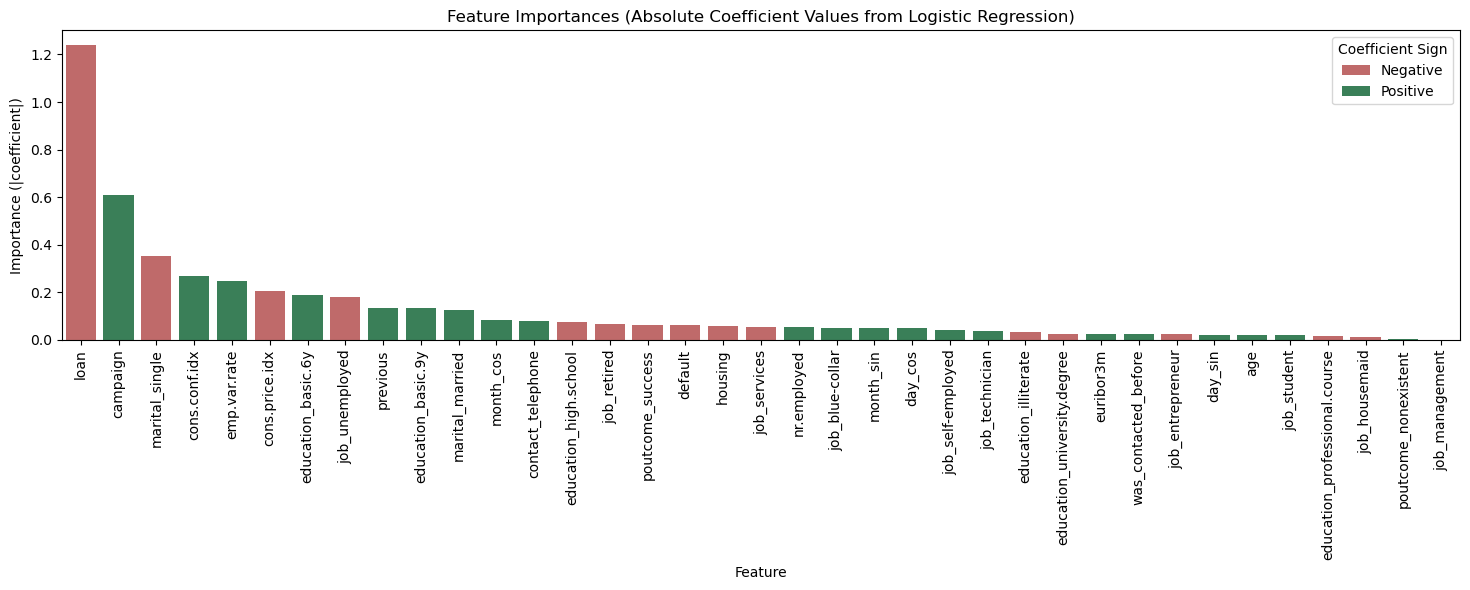

In [17]:
lr = pipes[0].named_steps["Logistic Regression"]

coefs = lr.coef_[0]
feature_names = X_train.columns

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'importance': np.abs(coefs)
})

# Sort by importance
coef_df = coef_df.sort_values(by='importance', ascending=False)
coef_df['sign'] = coef_df['coefficient'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')

# Sort by importance (already done in coef_df)
# coef_df = coef_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(max(10, len(coef_df) * 0.4), 6))
sns.barplot(
    data=coef_df,
    x='feature',
    y='importance',
    hue='sign',  # Color by sign
    dodge=False,  # No side-by-side bars
    palette={'Positive': 'seagreen', 'Negative': 'indianred'}
)
plt.title('Feature Importances (Absolute Coefficient Values from Logistic Regression)')
plt.ylabel('Importance (|coefficient|)')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.legend(title='Coefficient Sign')
plt.tight_layout()
plt.show()

## _Logistic Regression Coeficient Results_

#### _Impact Drivers_

- _By far the largest contributor to deciding whether someone will make a long term deposit subscription is whether or not they already have a loan_
- _The next largest contributor is the number of contacts that were made during the campaign_
- _Being single was correlated with not taking a long term deposit subsciption_
- _Addionally, anyone who was single was less likely to take a subscription_
- _The next three contributors were all indicators of the economy at that time, this implies whether someone will take a long term supscition is highly correlated to the economy_
- _Contact over telephone was preferable to cell phone_ 
- _Individauals with lower education were more likely to make subscriptions_
- _There also appears to be a slight seasonality to the decision with late fall and winter months producing more subscriptions_
- _Making contact in a previous campaign was correlated with success however, once success was achieved acquiring a new subscription became difficult_


#### _Simplifications_
- _Age doesn't seem to have much of an impact and can probably be dropped_
- _3 Month Euribor seems to have minimal imact and probably be dropped_
- _There are other items that are zero but tied to breaks in the data earlier that could also be dropped such as the people in managment and people with whom there was no previous outcome_



In [61]:
cols_to_drop = ['age', 'euribor3m']

X_train_reduced = X_train.drop(columns=cols_to_drop)
X_test_reduced = X_test.drop(columns=cols_to_drop)


In [62]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', penalty='l1'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced', C=0.01)
}

# Columns to scale (exclude normalized_columns)
cols_to_scale = [col for col in X_train_reduced.columns if col not in normalized_columns]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'
)

pipes, results = run_models(models, preprocessor, [X_train_reduced, X_test_reduced], [y_train, y_test])
display_results(results)


,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall
Model,,,,,
Logistic Regression,0.341,0.774,0.773,0.317,0.663
KNN,0.027,0.904,0.874,0.519,0.275
Decision Tree,0.086,0.951,0.803,0.289,0.370
SVM,14.125,0.722,0.721,0.274,0.714


_Let's see what what limiting the the number of branches in the decision tree does_

In [92]:
models = {
    "Decision Tree Depth = 1": DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=42),
    "Decision Tree Depth = 2": DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42),
    "Decision Tree Depth = 3": DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42),
    "Decision Tree Depth = 4": DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)    
}

# Columns to scale (exclude normalized_columns)
cols_to_scale = [col for col in X_train_reduced.columns if col not in normalized_columns]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[],
    remainder='passthrough'
)

pipes, results = run_models(models, preprocessor, [X_train_reduced, X_test_reduced], [y_train, y_test])
display_results(results)


,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall
Model,,,,,
Decision Tree Depth = 1,0.040,0.858,0.857,0.448,0.484
Decision Tree Depth = 2,0.040,0.817,0.819,0.376,0.617
Decision Tree Depth = 3,0.047,0.817,0.819,0.376,0.617
Decision Tree Depth = 4,0.050,0.850,0.851,0.439,0.587


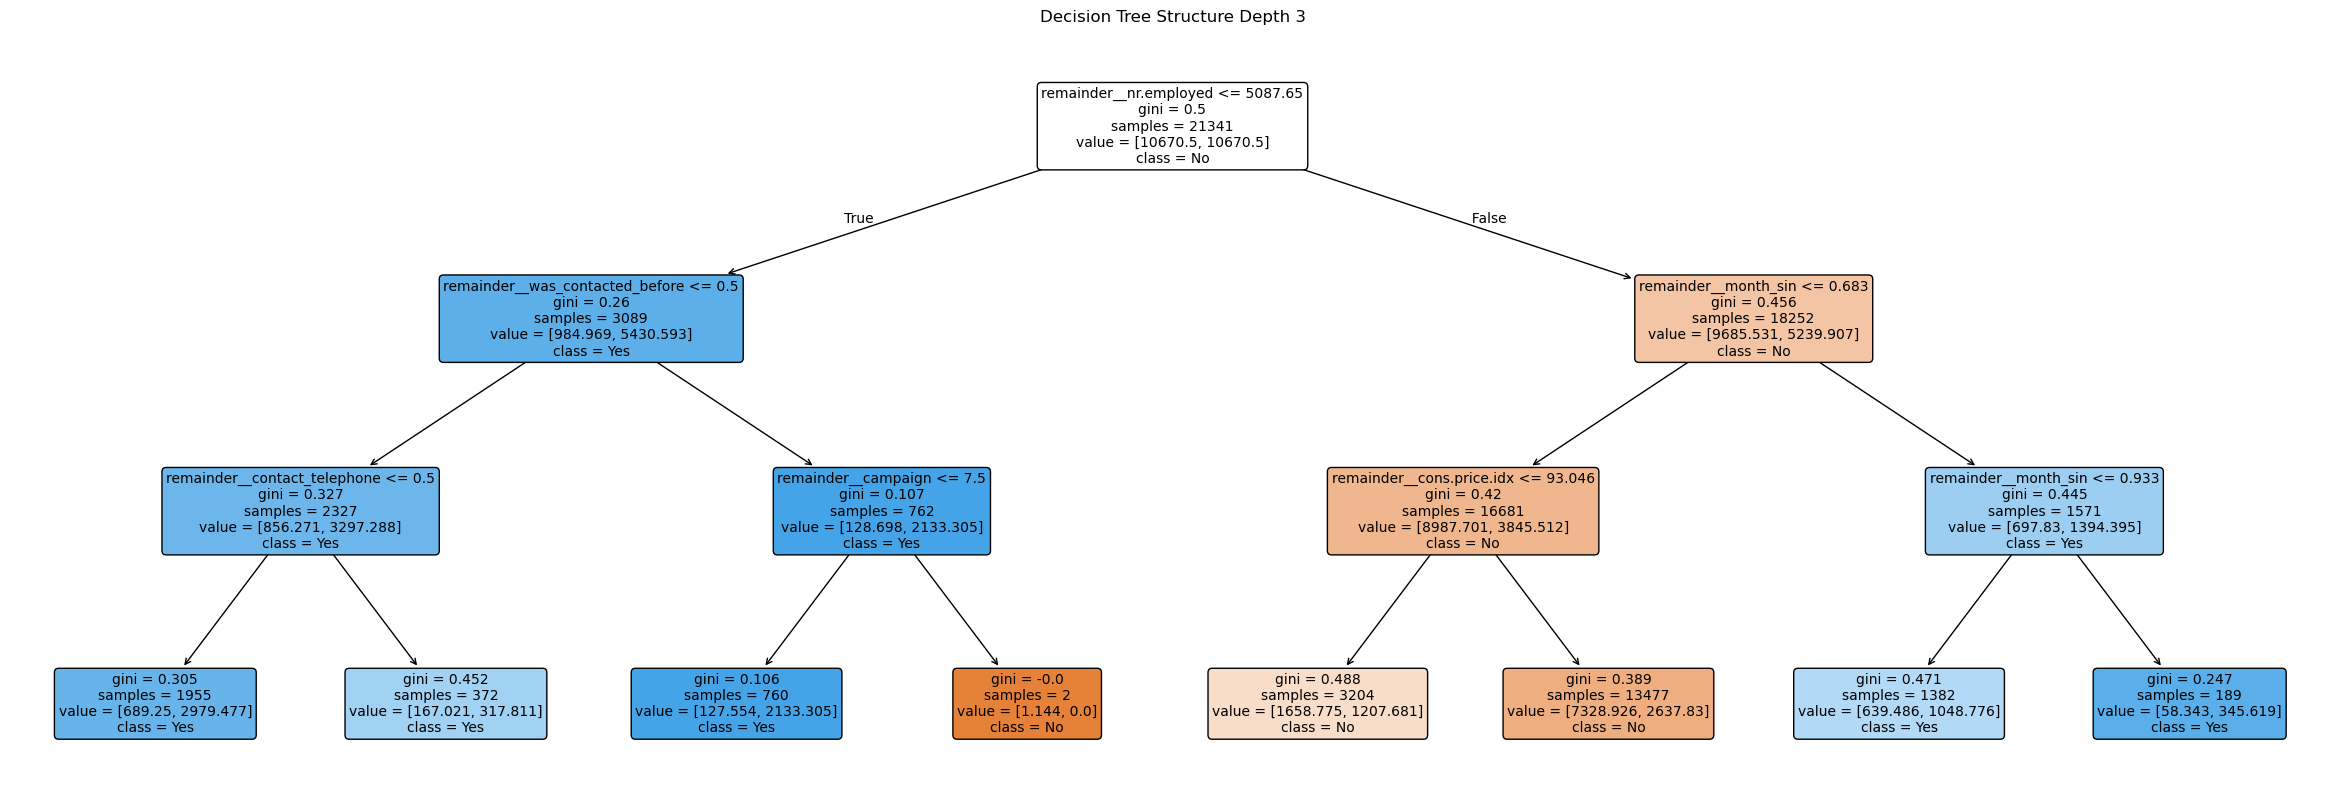

In [93]:
tree_model = pipes[2].named_steps['Decision Tree Depth = 3'] 

plt.figure(figsize=(30, 10))  # Adjust size as needed
plot_tree(
    tree_model,
    feature_names=preprocessor.get_feature_names_out(),  # Use your preprocessor if you have one
    class_names=['No', 'Yes'],  # Adjust to your target classes
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure Depth 3")
plt.show()

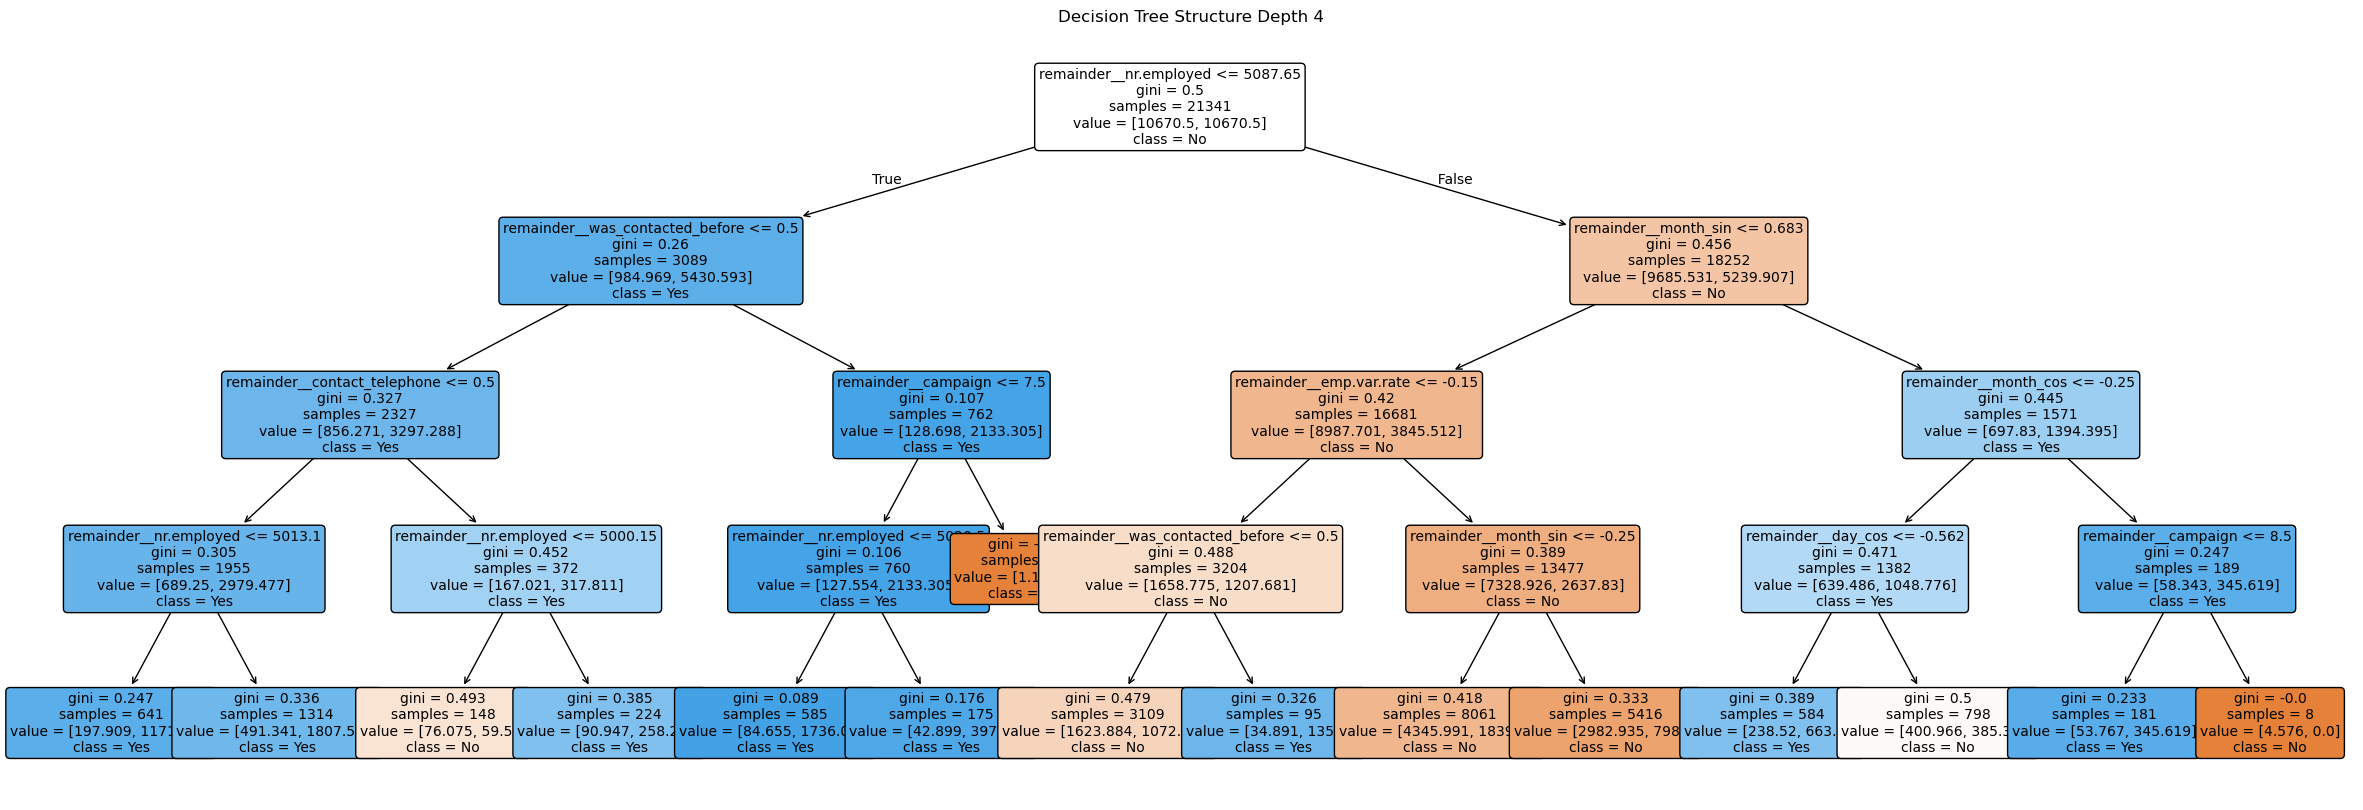

In [94]:
tree_model = pipes[3].named_steps['Decision Tree Depth = 4'] 

plt.figure(figsize=(30, 10))  # Adjust size as needed
plot_tree(
    tree_model,
    feature_names=preprocessor.get_feature_names_out(),  # Use your preprocessor if you have one
    class_names=['No', 'Yes'],  # Adjust to your target classes
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure Depth 4")
plt.show()



## _Decision Tree Results_

- _The Number of employees was the first item on which a decision was made.  This is a bit odd because one would think having more employees would lead to better customer service but instaead the opposite is true. Suggesting that maybe a core group delivering most of the results_
- _There is indeed a high degree of seasonality in the success of campaign since the next to levels use the month as an indicator_
- _There is also an economicfactor at play since the 3rd level decision on the emplyoment rate_
- _Finally not having been contacted before leeads to a higher success rate in most cases_ 


In [89]:

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


models = {
    "KNN 10  Neighbors": KNeighborsClassifier(n_neighbors=10),
    "KNN 20 Neighbors": KNeighborsClassifier(n_neighbors=20),
    "KNN 50 Neighbors": KNeighborsClassifier(n_neighbors=50),
    "KNN 100 Neighbors": KNeighborsClassifier(n_neighbors=100),
    "KNN 200 Neighbors": KNeighborsClassifier(n_neighbors=200),
}

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[],
    remainder='passthrough'
)

pipes, results = run_models(models, preprocessor, [X_resampled, X_test], [y_resampled, y_test])
display_results(results)

knn_50 = results[2]

## _KNN results_

- _Achieves reasonable accuracy quickly, Achieving higher recall requires resampling the data to balance the classes_
- _Roughly 10 neighbors gives the best result_ 
- _Training time is very quick_


In [71]:
models = {
    "SVM C=0.001": SVC(class_weight='balanced', C=0.001),
    "SVM C=0.01": SVC(class_weight='balanced', C=0.01),
    "SVM C=0.1": SVC(class_weight='balanced', C=0.1),
    "SVM C=1": SVC(class_weight='balanced', C=1),
    "SVM C=10": SVC(class_weight='balanced', C=10)
}

# Columns to scale (exclude normalized_columns)
cols_to_scale = [col for col in X_train_reduced.columns if col not in normalized_columns]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'
)

pipes, results = run_models(models, preprocessor, [X_train_reduced, X_test_reduced], [y_train, y_test])
display_results(results)

,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall
Model,,,,,
SVM C=0.001,16.137,0.753,0.748,0.278,0.606
SVM C=0.01,15.634,0.722,0.721,0.274,0.714
SVM C=0.1,12.528,0.786,0.784,0.329,0.660
SVM C=1,21.196,0.814,0.806,0.357,0.641
SVM C=10,28.599,0.861,0.814,0.357,0.566


In [79]:
models = {
    "SVM Linear kernel": SVC(class_weight='balanced', kernel='linear', C=0.01),
    "SVM RBF kernel": SVC(class_weight='balanced', kernel='rbf', C=0.01),
    "SVM Poly kernel": SVC(class_weight='balanced', kernel='poly', C=0.01),
    "SVM Sigmoid kernel": SVC(class_weight='balanced', kernel='sigmoid', C=0.01),
}

# Columns to scale (exclude normalized_columns)
cols_to_scale = [col for col in X_train_reduced.columns if col not in normalized_columns]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'
)

pipes, results = run_models(models, preprocessor, [X_train_reduced, X_test_reduced], [y_train, y_test])
display_results(results)

,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall
Model,,,,,
SVM Linear kernel,10.367,0.695,0.694,0.257,0.735
SVM RBF kernel,14.282,0.722,0.721,0.274,0.714
SVM Poly kernel,11.790,0.859,0.855,0.430,0.412
SVM Sigmoid kernel,14.843,0.695,0.694,0.257,0.734


In [90]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', penalty='l1'),
    "SVM Linear kernel": SVC(class_weight='balanced', kernel='linear', C=0.01),
    "Decision Tree Depth = 2": DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42),
}

# Columns to scale (exclude normalized_columns)
cols_to_scale = [col for col in X_train_reduced.columns if col not in normalized_columns]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'
)

pipes, results = run_models(models, preprocessor, [X_train_reduced, X_test_reduced], [y_train, y_test])

results.append(knn_50)
display_results(results)

,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall
Model,,,,,
Logistic Regression,0.368,0.774,0.773,0.317,0.663
SVM Linear kernel,10.298,0.695,0.694,0.257,0.735
Decision Tree Depth = 2,0.026,0.817,0.819,0.376,0.617
KNN 50 Neighbors,0.048,0.829,0.793,0.341,0.656


## _Conclusions and Results_

### _Results_
- _The SVC model with a linear kernel had the best recall results_ 
    - _Optimizing for recall is important as we want to ensure we don't miss candidates likely to make a long term deposit subscription_
    - _It also is slow to train and difficult to optimize_
- _Oddly a decision Tree of depth 2 had relatively decent results_
- _The KNN model required resampling the data for the KNN classifier to achieve parity with the other classifiers.  It also had the highest precsion_
- _In general, one can see the tradeoff between precision and recall driving one higher tends to driver the other lower_ 
- _Using logistic regression to deteremine the important Coefficients and then training a SVM model can be very benficial to reduce tcompute time_

### _Conclusions_
- _The fact that the decision tree decided to use the number of employees at the bank warrants further investigation to determine why?_
    - _Is it acatually a leading or trailing economic indicator?_
    - _Are there a core group of people who are augmented by seasonal employees?_
 ![DTREE3](images/dtree_3_level.png)
    
- _Based on the coeficients:_
    - _People with loans seem far less likely to make a long term deposit subscription_
    - _Having been a target of previous campains seems to indicate a person is more likely to make a subscription_
    - _Being single is correlated with not wanting a subscription_
    - _The economy plays significant roll in the success of getting a subscription_
    - _There is slight seasonality to the success of subscriptions particularly around the new year_

 ![Coefficients](images/coeficients.png)